## Importing Required Library
We begin by importing a few standard Python libraries that will be used to: 
* access ZIP files
* handle in-memory file objects
* load tabular data for analysis

In [1]:
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt

TERRA_ZIP = "../ERC20-stablecoins.zip"

## Checking Files in Terra_zip

In [2]:
with zipfile.ZipFile(TERRA_ZIP, "r") as z:
    terra_files = z.namelist()

terra_files

['token_transfers.csv',
 'token_transfers_V2.0.0.csv',
 'token_transfers_V3.0.0.csv',
 'price_data.zip',
 'event_data.csv']

In [ ]:
with zipfile.ZipFile("../ERC20-stablecoins.zip") as outer_zip:
    nested_zip_data = outer_zip.read("price_data.zip")
    with zipfile.ZipFile(io.BytesIO(nested_zip_data)) as inner_zip:
        with inner_zip.open("price_data/ustc_price_data.csv") as f:
            ust_price = pd.read_csv(f)
        with inner_zip.open("price_data/wluna_price_data.csv") as f:
            luna_price = pd.read_csv(f)
            
ust_price['date'] = pd.to_datetime(ust_price['timestamp'], unit='s')
luna_price['date'] = pd.to_datetime(luna_price['timestamp'], unit='s')

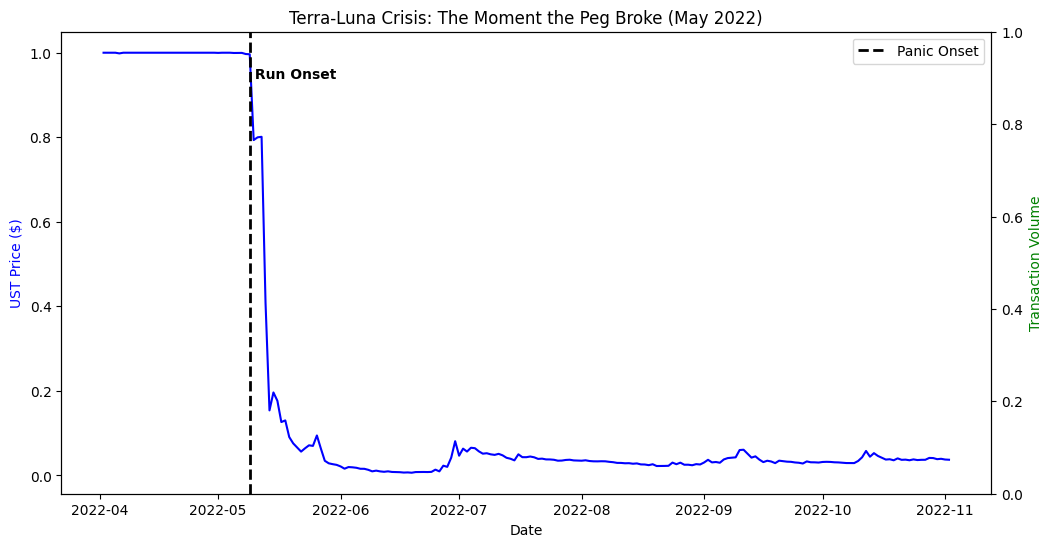

In [54]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('UST Price ($)', color='blue')
ax1.plot(ust_price['date'], ust_price['close'], color='blue', label='Price')
ax2 = ax1.twinx()
ax2.set_ylabel('Transaction Volume', color='green')
panic_onset = pd.to_datetime('2022-05-09')
plt.axvline(x=panic_onset, color='black', linestyle='--', linewidth=2, label='Panic Onset')
plt.text(panic_onset, plt.ylim()[1]*0.9, ' Run Onset', color='black', fontweight='bold')
plt.legend()
plt.title('Terra-Luna Crisis: The Moment the Peg Broke (May 2022)')
plt.show()

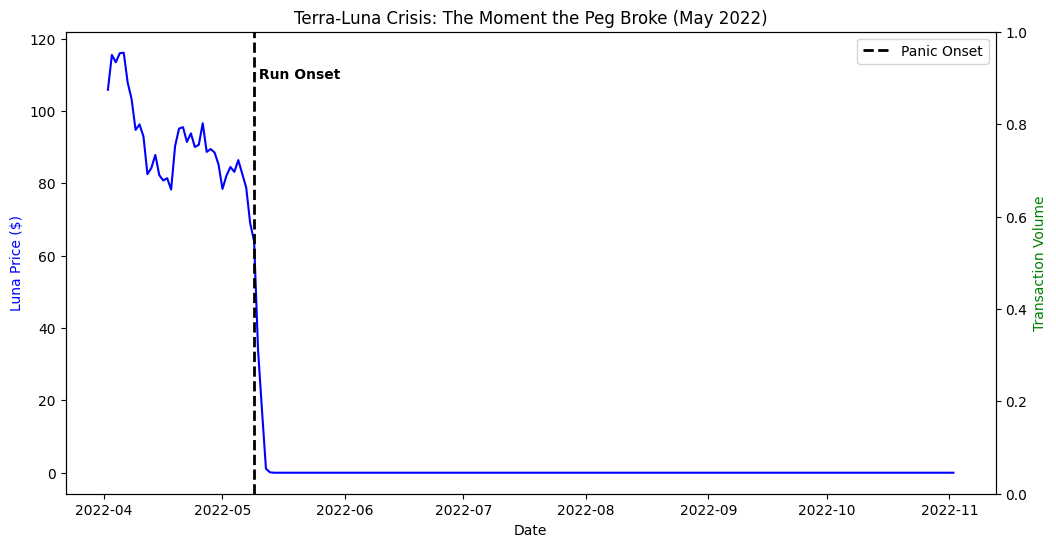

In [55]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Luna Price ($)', color='blue')
ax1.plot(luna_price['date'], luna_price['close'], color='blue', label='Price')
ax2 = ax1.twinx()
ax2.set_ylabel('Transaction Volume', color='green')
panic_onset = pd.to_datetime('2022-05-09')
plt.axvline(x=panic_onset, color='black', linestyle='--', linewidth=2, label='Panic Onset')
plt.text(panic_onset, plt.ylim()[1]*0.9, ' Run Onset', color='black', fontweight='bold')
plt.legend()
plt.title('Terra-Luna Crisis: The Moment the Peg Broke (May 2022)')
plt.show()

We could see a huge drop after 2025-05-08, this is the time when the confidence drop. Hence we will analyse the data around May 2022

## Load sample of token transfer

In [ ]:
TRANSFERS_FILE = ["token_transfers.csv", "token_transfers_V2.0.0.csv", "token_transfers_V3.0.0.csv"]  

with zipfile.ZipFile(TERRA_ZIP) as z:
    with z.open(TRANSFERS_FILE[0]) as f:
        token_transfers_v1_top5 = pd.read_csv(f, nrows=5)
    with z.open(TRANSFERS_FILE[1]) as f:
        token_transfers_v2_top5 = pd.read_csv(f, nrows=5)
    with z.open(TRANSFERS_FILE[2]) as f:
        token_transfers_v3_top5 = pd.read_csv(f, nrows=5)


In [20]:
token_transfers_v1_top5["timestamp"] = pd.to_datetime(token_transfers_v1_top5["time_stamp"], unit="s", errors="coerce", utc=True)
token_transfers_v1_top5[["time_stamp", "timestamp"]].head(3), (token_transfers_v1_top5["timestamp"].min(), token_transfers_v1_top5["timestamp"].max())

(   time_stamp                 timestamp
 0  1651105815 2022-04-28 00:30:15+00:00
 1  1651105815 2022-04-28 00:30:15+00:00
 2  1651105815 2022-04-28 00:30:15+00:00,
 (Timestamp('2022-04-28 00:30:15+0000', tz='UTC'),
  Timestamp('2022-04-28 00:30:15+0000', tz='UTC')))

In [21]:
token_transfers_v2_top5["timestamp"] = pd.to_datetime(token_transfers_v2_top5["time_stamp"], unit="s", errors="coerce", utc=True)
token_transfers_v2_top5[["time_stamp", "timestamp"]].head(3), (token_transfers_v2_top5["timestamp"].min(), token_transfers_v2_top5["timestamp"].max())

(   time_stamp                 timestamp
 0  1651105815 2022-04-28 00:30:15+00:00
 1  1651105815 2022-04-28 00:30:15+00:00
 2  1651105815 2022-04-28 00:30:15+00:00,
 (Timestamp('2022-04-28 00:30:15+0000', tz='UTC'),
  Timestamp('2022-04-28 00:30:15+0000', tz='UTC')))

In [22]:
token_transfers_v3_top5["timestamp"] = pd.to_datetime(token_transfers_v3_top5["time_stamp"], unit="s", errors="coerce", utc=True)
token_transfers_v3_top5[["time_stamp", "timestamp"]].head(3), (token_transfers_v3_top5["timestamp"].min(), token_transfers_v3_top5["timestamp"].max())

(   time_stamp                 timestamp
 0  1648811421 2022-04-01 11:10:21+00:00
 1  1648811421 2022-04-01 11:10:21+00:00
 2  1648811421 2022-04-01 11:10:21+00:00,
 (Timestamp('2022-04-01 11:10:21+0000', tz='UTC'),
  Timestamp('2022-04-01 11:10:24+0000', tz='UTC')))

In [37]:
TRANSFERS_FILE = ["token_transfers.csv", "token_transfers_V2.0.0.csv", "token_transfers_V3.0.0.csv"]  

with zipfile.ZipFile(TERRA_ZIP) as z:
    with z.open(TRANSFERS_FILE[0]) as f:
        token_transfers_v1_full = pd.read_csv(f)
    with z.open(TRANSFERS_FILE[1]) as f:
        token_transfers_v2_full = pd.read_csv(f)
    with z.open(TRANSFERS_FILE[2]) as f:
        token_transfers_v3_full = pd.read_csv(f)


## Check Schema

In [ ]:
# df.columns.tolist(), df.dtypes

token_transfers_v1_full.info()
token_transfers_v1_full.head()


<class 'pandas.DataFrame'>
RangeIndex: 5280131 entries, 0 to 5280130
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   block_number       int64  
 1   transaction_index  int64  
 2   from_address       str    
 3   to_address         str    
 4   time_stamp         int64  
 5   contract_address   str    
 6   value              float64
dtypes: float64(1), int64(3), str(3)
memory usage: 282.0 MB


,block_number,transaction_index,from_address,to_address,time_stamp,contract_address,value
0,14669683,7,0xd30b438df65f4f788563b2b3611bd6059bff4ad9,0xda816e2122a8a39b0926bfa84edd3d42477e9efd,1651105815,0xdac17f958d2ee523a2206206994597c13d831ec7,18.670000
1,14669683,45,0x4941834ed1428089ee76252f6f9d767e800499b0,0x28c6c06298d514db089934071355e5743bf21d60,1651105815,0xdac17f958d2ee523a2206206994597c13d831ec7,10000.000000
2,14669683,46,0x2c1f9a20711e14f8484a41123e20d1b06858ebea,0x28c6c06298d514db089934071355e5743bf21d60,1651105815,0xdac17f958d2ee523a2206206994597c13d831ec7,9942.313005
3,14669683,47,0x7784c4f53aa5f03bd6d3ca670c9d9c887cc38cb0,0x3cd751e6b0078be393132286c442345e5dc49699,1651105815,0xdac17f958d2ee523a2206206994597c13d831ec7,234.364097
4,14669683,48,0x66589b8278470d58d4112f3d065de0f75734312e,0x28c6c06298d514db089934071355e5743bf21d60,1651105815,0xdac17f958d2ee523a2206206994597c13d831ec7,9800.000000


In [39]:
token_transfers_v2_full.info()
token_transfers_v2_full.head()

<class 'pandas.DataFrame'>
RangeIndex: 28674511 entries, 0 to 28674510
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   block_number       int64  
 1   transaction_index  int64  
 2   from_address       str    
 3   to_address         str    
 4   time_stamp         int64  
 5   contract_address   str    
 6   value              float64
dtypes: float64(1), int64(3), str(3)
memory usage: 1.5 GB


,block_number,transaction_index,from_address,to_address,time_stamp,contract_address,value
0,14669683,7,0xd30b438df65f4f788563b2b3611bd6059bff4ad9,0xda816e2122a8a39b0926bfa84edd3d42477e9efd,1651105815,0xdac17f958d2ee523a2206206994597c13d831ec7,18.670000
1,14669683,45,0x4941834ed1428089ee76252f6f9d767e800499b0,0x28c6c06298d514db089934071355e5743bf21d60,1651105815,0xdac17f958d2ee523a2206206994597c13d831ec7,10000.000000
2,14669683,46,0x2c1f9a20711e14f8484a41123e20d1b06858ebea,0x28c6c06298d514db089934071355e5743bf21d60,1651105815,0xdac17f958d2ee523a2206206994597c13d831ec7,9942.313005
3,14669683,47,0x7784c4f53aa5f03bd6d3ca670c9d9c887cc38cb0,0x3cd751e6b0078be393132286c442345e5dc49699,1651105815,0xdac17f958d2ee523a2206206994597c13d831ec7,234.364097
4,14669683,48,0x66589b8278470d58d4112f3d065de0f75734312e,0x28c6c06298d514db089934071355e5743bf21d60,1651105815,0xdac17f958d2ee523a2206206994597c13d831ec7,9800.000000


In [40]:
token_transfers_v3_full.info()
token_transfers_v3_full.head()

<class 'pandas.DataFrame'>
RangeIndex: 36723655 entries, 0 to 36723654
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   block_number       int64  
 1   transaction_index  int64  
 2   from_address       str    
 3   to_address         str    
 4   time_stamp         int64  
 5   contract_address   str    
 6   value              float64
dtypes: float64(1), int64(3), str(3)
memory usage: 1.9 GB


,block_number,transaction_index,from_address,to_address,time_stamp,contract_address,value
0,14500001,44,0x27cbb0e6885ccb1db2dab7c2314131c94795fbef,0x8426a27add8dca73548f012d92c7f8f4bbd42a3e,1648811421,0xdac17f958d2ee523a2206206994597c13d831ec7,800.000000
1,14500001,62,0x7938b1b2f2d2ec6cde2db46fcb11d824f32eae54,0xffabc91efaf240a48fe2b31d3599925d3504c3df,1648811421,0xdac17f958d2ee523a2206206994597c13d831ec7,579.000000
2,14500001,64,0x4593e0fb8dcc65cd24c7f99ee64da2627e90f998,0x97138e4cb36db0185236c3d74cb39fb51cb3228b,1648811421,0xdac17f958d2ee523a2206206994597c13d831ec7,15898.000000
3,14500001,68,0x3cd751e6b0078be393132286c442345e5dc49699,0xf4fc2e12974cc3b4d8192722430c571968025d4f,1648811421,0xdac17f958d2ee523a2206206994597c13d831ec7,200.929675
4,14500003,0,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,0x5b0e981798f5880c25b54c5de4005f5ec1f3f46a,1648811424,0xdac17f958d2ee523a2206206994597c13d831ec7,651.675449


## Converting Timestamps

In [41]:
token_transfers_v1_full["timestamp"] = pd.to_datetime(token_transfers_v1_full["time_stamp"], unit="s", errors="coerce", utc=True)
token_transfers_v1_full[["time_stamp", "timestamp"]].head(3), (token_transfers_v1_full["timestamp"].min(), token_transfers_v1_full["timestamp"].max())


(   time_stamp                 timestamp
 0  1651105815 2022-04-28 00:30:15+00:00
 1  1651105815 2022-04-28 00:30:15+00:00
 2  1651105815 2022-04-28 00:30:15+00:00,
 (Timestamp('2022-04-28 00:30:15+0000', tz='UTC'),
  Timestamp('2022-05-25 18:47:44+0000', tz='UTC')))

In [42]:
token_transfers_v2_full["timestamp"] = pd.to_datetime(token_transfers_v2_full["time_stamp"], unit="s", errors="coerce", utc=True)
token_transfers_v2_full[["time_stamp", "timestamp"]].head(3), (token_transfers_v2_full["timestamp"].min(), token_transfers_v2_full["timestamp"].max())


(   time_stamp                 timestamp
 0  1651105815 2022-04-28 00:30:15+00:00
 1  1651105815 2022-04-28 00:30:15+00:00
 2  1651105815 2022-04-28 00:30:15+00:00,
 (Timestamp('2022-04-28 00:30:15+0000', tz='UTC'),
  Timestamp('2022-10-07 02:38:47+0000', tz='UTC')))

In [45]:
token_transfers_v3_full["timestamp"] = pd.to_datetime(token_transfers_v3_full["time_stamp"], unit="s", errors="coerce", utc=True)
token_transfers_v3_full[["time_stamp", "timestamp"]].head(3), (token_transfers_v3_full["timestamp"].min(), token_transfers_v3_full["timestamp"].max())


(   time_stamp                 timestamp
 0  1648811421 2022-04-01 11:10:21+00:00
 1  1648811421 2022-04-01 11:10:21+00:00
 2  1648811421 2022-04-01 11:10:21+00:00,
 (Timestamp('2022-04-01 11:10:21+0000', tz='UTC'),
  Timestamp('2022-11-01 04:53:59+0000', tz='UTC')))

## Clean ```value``` column

In [46]:
token_transfers_v3_full["value"] = pd.to_numeric(token_transfers_v3_full["value"], errors="coerce")
token_transfers_v3_full["value"].describe()


count    3.672366e+07
mean     6.324733e+05
std      2.690748e+08
min      0.000000e+00
25%      1.956300e+02
50%      1.030479e+03
75%      7.387074e+03
max      6.767923e+11
Name: value, dtype: float64

In [47]:
contract_to_token = {
    "0x6b175474e89094c44da98b954eedeac495271d0f": "DAI",
    "0x8e870d67f660d95d5be530380d0ec0bd388289e1": "PAX",
    "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48": "USDC",
    "0xdac17f958d2ee523a2206206994597c13d831ec7": "USDT",
    "0xa47c8bf37f92abed4a126bda807a7b7498661acd": "USTC",
    "0xd2877702675e6ceb975b4a1dff9fb7baf4c91ea9": "WLUNA",
}

token_transfers_v3_full["token"] = token_transfers_v3_full["contract_address"].map(contract_to_token)

In [48]:
top_contracts = token_transfers_v3_full["token"].value_counts()
top_contracts


token
USDT     19283678
USDC     14541856
DAI       2139931
WLUNA      454150
USTC       237608
PAX         66432
Name: count, dtype: int64

In [49]:
df_small = token_transfers_v3_full.dropna(subset=["timestamp", "token", "value"]).copy()

hourly_by_contract = (
    df_small.set_index("timestamp")
            .groupby("token")
            .resample("1h")
            .agg(gross_transfer_volume=("value", "sum"),
                 num_transfers=("value", "size"))
            .reset_index()
)

hourly_by_contract.head()


,token,timestamp,gross_transfer_volume,num_transfers
0,DAI,2022-04-01 11:00:00+00:00,2.174219e+07,333
1,DAI,2022-04-01 12:00:00+00:00,1.555625e+08,527
2,DAI,2022-04-01 13:00:00+00:00,8.395249e+07,563
3,DAI,2022-04-01 14:00:00+00:00,3.416577e+07,502
4,DAI,2022-04-01 15:00:00+00:00,2.886561e+07,540


In [50]:
N = 6

top_contract_list = top_contracts.index[:N].tolist()

top_contract_list

hourly_top = hourly_by_contract[
    hourly_by_contract["token"].isin(top_contract_list)
].copy()

hourly_top.head()

,token,timestamp,gross_transfer_volume,num_transfers
0,DAI,2022-04-01 11:00:00+00:00,2.174219e+07,333
1,DAI,2022-04-01 12:00:00+00:00,1.555625e+08,527
2,DAI,2022-04-01 13:00:00+00:00,8.395249e+07,563
3,DAI,2022-04-01 14:00:00+00:00,3.416577e+07,502
4,DAI,2022-04-01 15:00:00+00:00,2.886561e+07,540


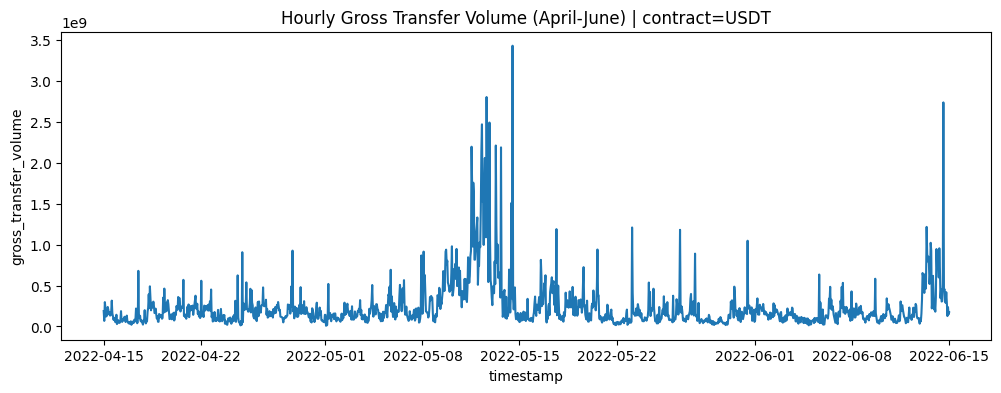

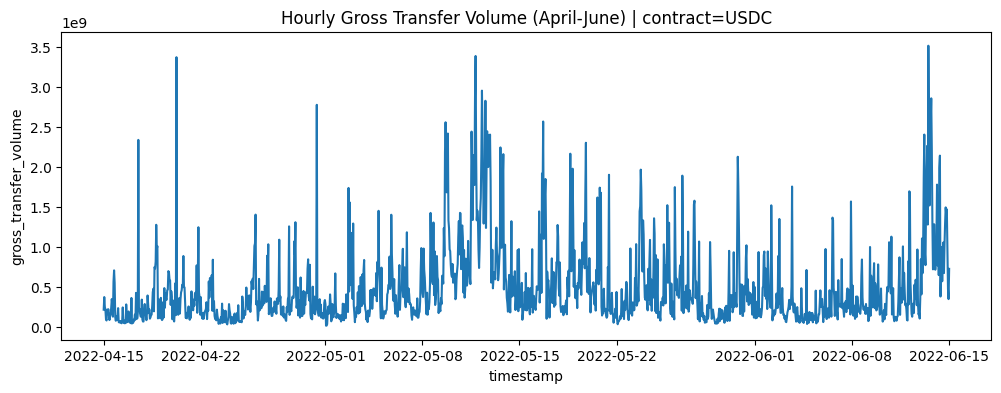

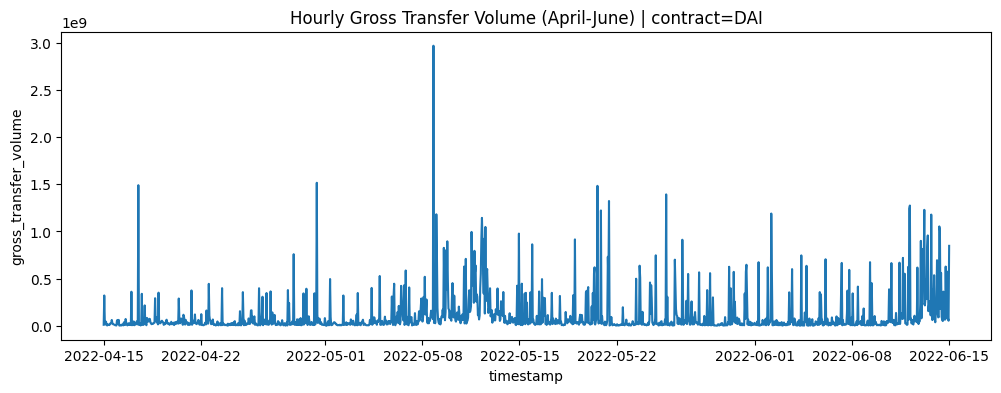

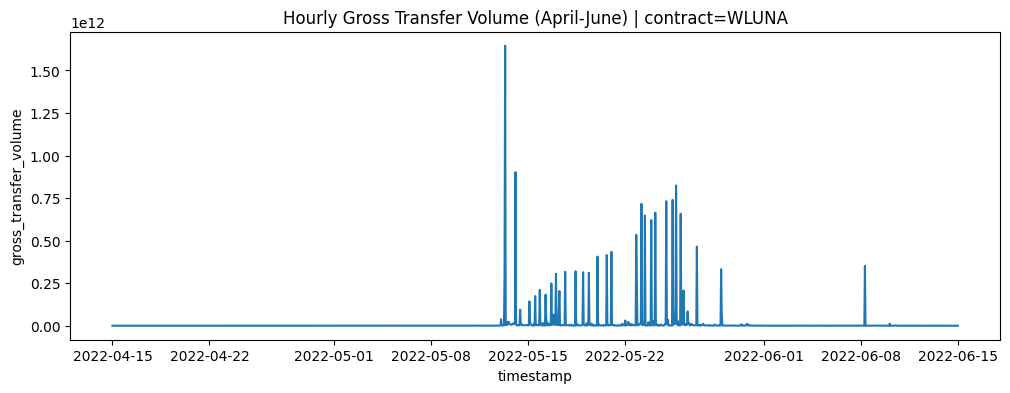

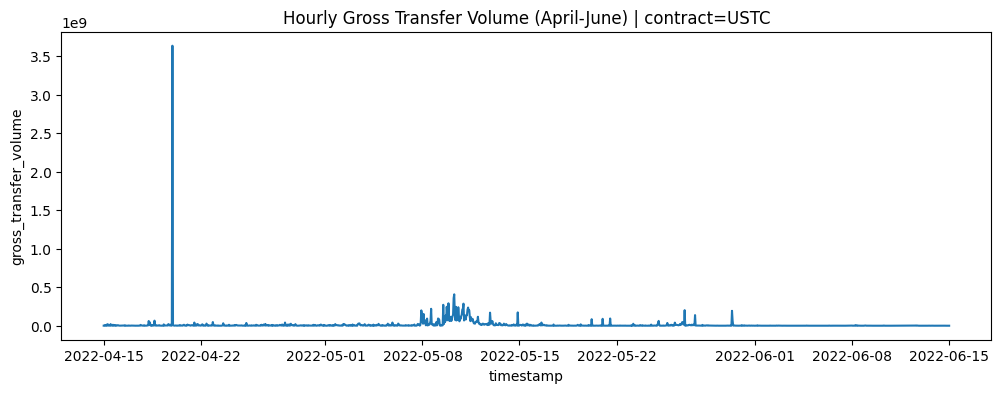

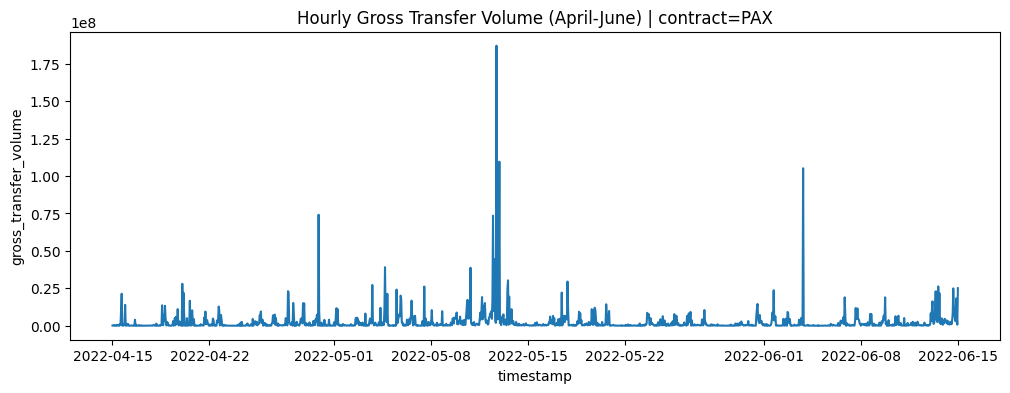

In [57]:
start_date = "2022-04-15"
end_date = "2022-06-15"

hourly_top_filtered = hourly_top[
    (hourly_top["timestamp"] >= start_date) & 
    (hourly_top["timestamp"] <= end_date)
].copy()

for c in top_contract_list:
    sub = hourly_top_filtered[hourly_top_filtered["token"] == c]
    plt.figure(figsize=(12,4))
    plt.plot(sub["timestamp"], sub["gross_transfer_volume"])
    
    plt.title(f"Hourly Gross Transfer Volume (April-June) | contract={c}")
    plt.xlabel("timestamp")
    plt.ylabel("gross_transfer_volume")
    plt.show()